<a href="https://colab.research.google.com/github/schukinam/otus_dl/blob/master/lesson3_pytorch_mnist_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# from utils import mnist

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

In [0]:
def mnist(batch_size=50, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    train_loader = utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    test_loader = utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [5]:
train_loader, test_loader = mnist()

0it [00:00, ?it/s]

9920512it [00:02, 3713244.67it/s]                             


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57864.06it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


1654784it [00:01, 977109.97it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


8192it [00:00, 21741.11it/s]            

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...
Done!


#### Задание:
#### 2. Добиться от классифкатора на minst переобучения за счет изменения архитектуры и гиперпараметров.

In [0]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        # Будем добиваться переобучения с помощью слоя с очень большим количеством нейронов,
        # веса которых смогут излишне подстроиться под обучающий датасет
        self.fc1 = nn.Linear(28*28, 2048)
        self.fc2 = nn.Linear(2048, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
        self.train_losses_ = list()
        self.test_losses_ = list()
        self.train_accs_ = list()
        self.test_accs_ = list()
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss
    
    def _append_metric_value(self, metric, value):
        if metric == 'train_loss':
            self.train_losses_.append(value)
        if metric == 'test_loss':
            self.test_losses_.append(value)
        if metric == 'train_acc':
            self.train_accs_.append(value)
        if metric == 'test_acc':
            self.test_accs_.append(value)
        return self

In [0]:
def fit(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
    else:
        batch_idx += 1
        for i, model in enumerate(models):
            # рассчитываем loss и acc на целых датасетах train и test, а не на отдельном мини-батче
            train_loss, train_acc = train_set_metrics(model)
            test_loss, test_acc = test_set_metrics(model)
            model._append_metric_value('train_loss', train_loss)
            model._append_metric_value('train_acc', train_acc)
            model._append_metric_value('test_loss', test_loss)
            model._append_metric_value('test_acc', test_acc)
            line = 'Model: {} | Train Epoch: {} | '.format(i, epoch) + \
                'Train Loss: {:.4f} | Test Loss: {:.4f} | Train Acc: {:.4f} | Test Acc: {:.4f}'.format(
                train_loss, test_loss, train_acc, test_acc)
            print(line)

In [0]:
def train_set_metrics(model):
    loss = 0.
    acc = 0.
    with torch.no_grad():
        for data, target in train_loader:
            output = model(data)
            loss += model.loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            acc += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    loss /= len(train_loader.dataset)
    acc /= len(train_loader.dataset)
    return loss, acc

In [0]:
def test_set_metrics(model):
    loss = 0.
    acc = 0.
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss += model.loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            acc += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    loss /= len(test_loader.dataset)
    acc /= len(test_loader.dataset)
    return loss, acc

In [0]:
def plot_graph(model, metric, epochs):
    plt.title('Model fit')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    if metric == 'Loss':
        plt.plot(model.train_losses_[:epochs], color='green', label='train')
        plt.plot(model.test_losses_[:epochs], color='red', label='test')
    if metric == 'Accuracy':        
        plt.plot(model.train_accs_[:epochs], color='green', label='train')
        plt.plot(model.test_accs_[:epochs], color='red', label='test')
    plt.legend()
    plt.show() 

In [0]:
models = [Net(True)]

In [12]:
for epoch in range(1, 101):
    fit(epoch, models)

Model: 0 | Train Epoch: 1 | Train Loss: 0.6699 | Test Loss: 0.7222 | Train Acc: 0.8347 | Test Acc: 0.8317
Model: 0 | Train Epoch: 2 | Train Loss: 0.5716 | Test Loss: 0.6352 | Train Acc: 0.8698 | Test Acc: 0.8632
Model: 0 | Train Epoch: 3 | Train Loss: 0.5229 | Test Loss: 0.5883 | Train Acc: 0.8823 | Test Acc: 0.8782
Model: 0 | Train Epoch: 4 | Train Loss: 0.3576 | Test Loss: 0.4431 | Train Acc: 0.9159 | Test Acc: 0.9091
Model: 0 | Train Epoch: 5 | Train Loss: 0.3131 | Test Loss: 0.4054 | Train Acc: 0.9312 | Test Acc: 0.9215
Model: 0 | Train Epoch: 6 | Train Loss: 0.3250 | Test Loss: 0.4396 | Train Acc: 0.9230 | Test Acc: 0.9092
Model: 0 | Train Epoch: 7 | Train Loss: 0.2718 | Test Loss: 0.4093 | Train Acc: 0.9363 | Test Acc: 0.9302
Model: 0 | Train Epoch: 8 | Train Loss: 0.2654 | Test Loss: 0.4255 | Train Acc: 0.9396 | Test Acc: 0.9276
Model: 0 | Train Epoch: 9 | Train Loss: 0.2511 | Test Loss: 0.4147 | Train Acc: 0.9488 | Test Acc: 0.9331
Model: 0 | Train Epoch: 10 | Train Loss: 0.198

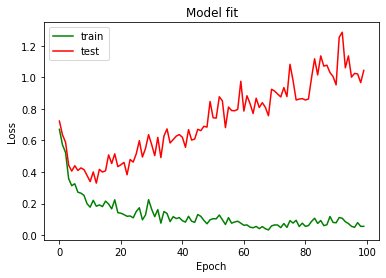

In [13]:
plot_graph(models[0], 'Loss', 100)

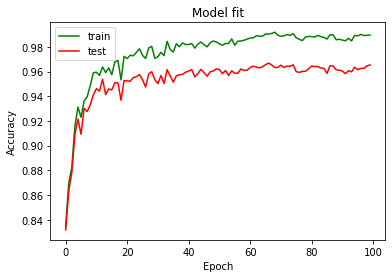

In [14]:
plot_graph(models[0], 'Accuracy', 100)

#### Вопрос из slack:

Artur Kadurin 3:16 PM

я понял, что я внес некоторый рандом в дз про перееобучение. обычно, когда говорят про перееобучение подразумевают зазор между ошибкой на трейне и тесте, имея в виду что реальное качество модели перестало расти, а мы глядя только на трейн не можем этого понять и кажется что модель учится дальше.

но в этом дз у многих вощникла ситуация, когда начиная с какого-то момента ошибка на тесте не просто перестает уменьшаться, а еще и начинает расти. в связи с этим я прошу всех заодно посмотреть и на график accuracy и сделать вывод о том, как так выходит, что лосс растет, а точность не падает.

#### Предположительный вывод:

Рассмотрим пример из тестового множества, на котором модель ошибается. В процессе переобучения модель, подстраиваясь под обучающий датасет, может всё больше и больше ошибаться на данном примере, то есть уменьшать вероятность qi правильного ответа pi, из-за чего NLL будет расти, т.к. считается с помощью суммирования слагаемых -pi*log(qi). При этом Accuracy не меняется, т.к. на выходе модель продолжает возвращать одинаково неверный ответ.

В то же время в некоторых случаях граничных классов возможен переход от неправильного ответа к правильному, то есть теоретически Accuracy может даже расти при растущем NLL. 